# Simulation of PID controller

In order to test the PID controller, an **armature controlled permanent magnet dc motor** was
selected.

Motor parameters
* Kt (torque constant) = 0.06 Nm/A
* Ke (voltage constant) = 0.06 Vs/rad
* L (armature inductance) = 0.02 H
* R (armature resistance) = 1.2 Ohm
* J (inertia) = 6.2e−4 Nm^2/rad
* B (friction coefficient)= 0.0001 Nms/rad

### Transfer function for _motor_
The transfer function of the motor between the armature voltage and the motor speed is as
follows.

$$ \frac{\Omega(s)}{E(s)} =\frac{K_t}{RJs^2+(RJ+BL)s+(K_tK_e+RB)} $$

Substituting the values for the selected motor

$$ \frac{\Omega(s)}{E(s)} =\frac{0.06}{1.24\times 10^{-4} s^2 + 0.000746 s+0.00372} $$

### Transfer function for _plant_

We can practically use a microcontroller to generate a PWM which will in turn control the input voltage to the motor. To do this we need a motor drive (ex: L298n IC). 
The block diagram of the plant is as follows. Here, the controller output is the duty cycle for the PWM. Plant output is the motor speed.


![plant](/images/plant.svg)

If we assume the motor controller is linear, then we can consider the effect of both the PWM generator and motor drive as scaling the duty cycle by a constant. i.e., the transfer function is a constant. Therefore, we can express the transfer function for the complete plant as follows. Here Ω is the angular speed and 𝐷 is the duty ratio.

$$ \frac{\Omega(s)}{D(s)} =\frac{24\times0.06}{1.24\times 10^{-4} s^2 + 0.000746 s+0.00372} $$


### Control algorithm

![control](/images/system.svg)

Now we can go on to test and tune out PID controller for the selected plant. To implement the transfer function and obtain the response at a given point, the Python Control Systems library has been used (https://pypi.org/project/control). Additionally, the NumPy library was used for matrix manipulation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control

# importing the coded control algorithm (shown above)
from pid_controller import SimplePIDController

In [2]:
# simulate the control loop for each sample time
def simulate(G, dt, pid, ref):

    t = np.arange(0,1,dt)  # response was obtained for 1s

    x_prev = np.zeros(len(G.pole())) # variable to store previous state of system

    # vectors to store outputs
    y_vect = np.zeros(len(t))  # output speed (measured speed)
    pwm_vect = np.zeros(len(t))  # PWM duty cycle (control signal)

    # simulate the control loop for each sample time
    for i, t_i in enumerate(t):
        pwm = pid.update_pid(ref, y_vect[i-1])  # call update functio of PID
        pwm_vect[i] = pwm
        t_temp, y_temp, x_temp = control.forced_response(G,[t_i-dt,t_i],[pwm,pwm], X0=x_prev, return_x=True, squeeze=True)
        y_vect[i] = y_temp[-1]
        x_prev = x_temp[:,-1]

    return y_vect, pwm_vect, t

In [3]:
# define transfer function
G = control.TransferFunction(1.44, [1.24e-5, 0.000746, 0.00327]) 

dt = 0.001 # sample time

# PID gains
kp = 0.1
ki = 0.5
kd = 0.004

# create an instance of the PID controller
pid = SimplePIDController(kp=kp, ki=ki, kd=kd, lim_min=0, lim_max=0.95, T=dt)


ref = 50 # reference speed

# simulation
y, pwm, t = simulate(G, dt, pid, ref)

C:\Users\Sathira\anaconda3\envs\myenv\lib\site-packages\control\timeresp.py:293: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


Text(0, 0.5, 'Duty ratio')

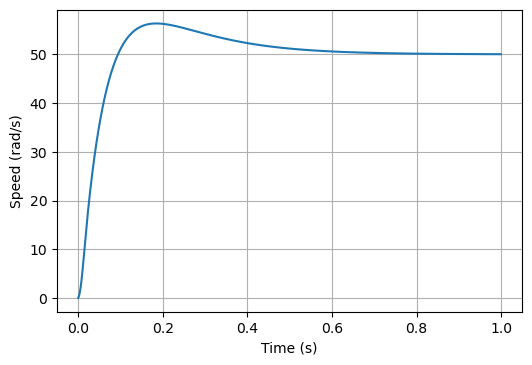

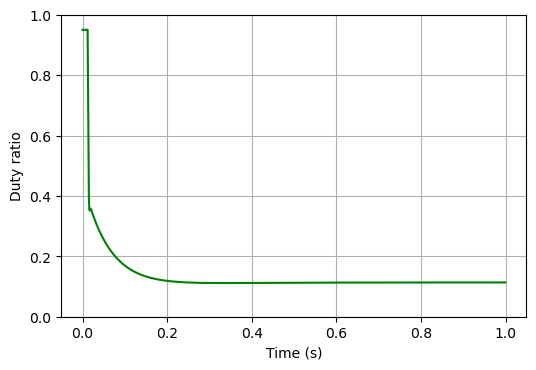

In [4]:
# Plotting the results

# motor speed (plant output)
ax = plt.figure(dpi=100).gca()
ax.plot(t, y)
ax.grid()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Speed (rad/s)")

# duty ratio (control signal)
ax = plt.figure(dpi=100).gca()
ax.plot(t,pwm,'g')
ax.set_ylim([0,1])
ax.grid()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Duty ratio")